In [1]:
!pip install harmonica numpy matplotlib scip

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of ome-zarr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 1

Complex geological models (Density & K, U, Th) created.
Calculating gravity anomaly (including topographic effects)...
Gravity calculation complete. Anomaly range: 28284.63 to 1870260.76 mGal
Radiometric calculation complete (with soil muting everywhere).


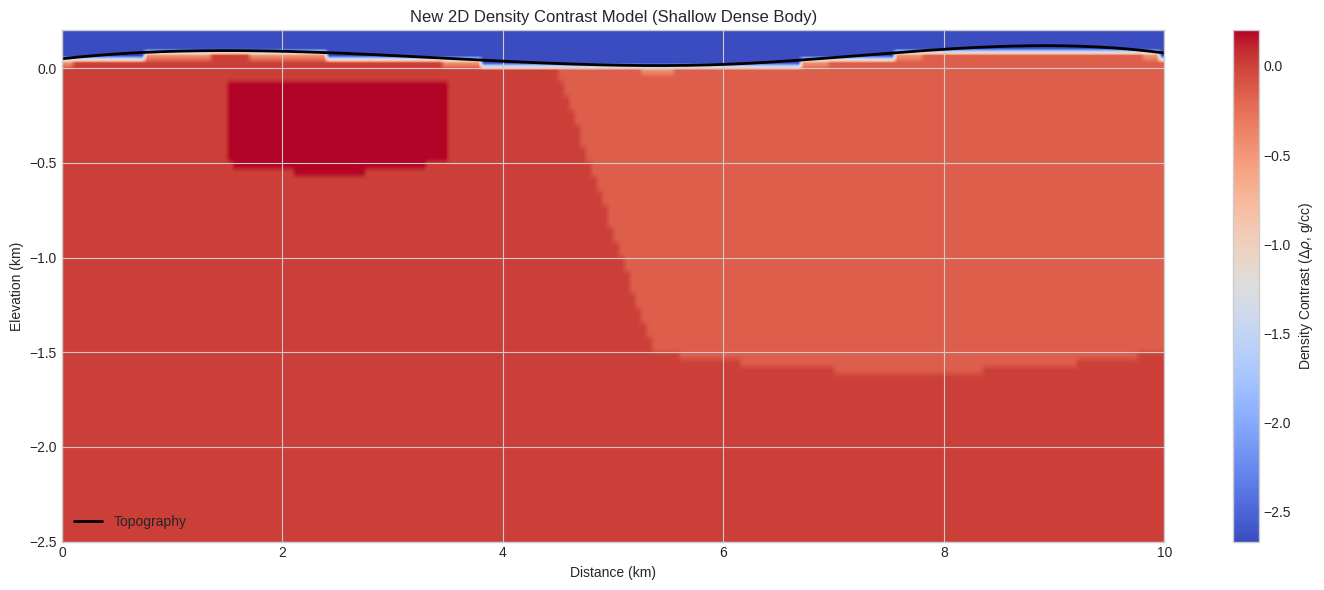

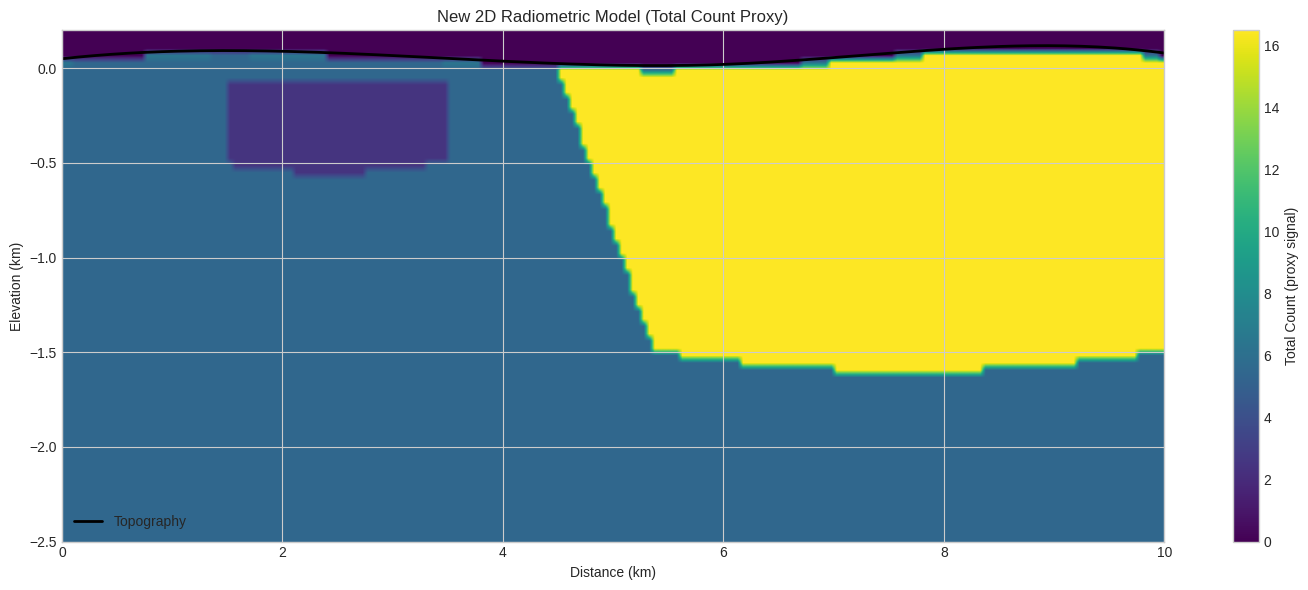

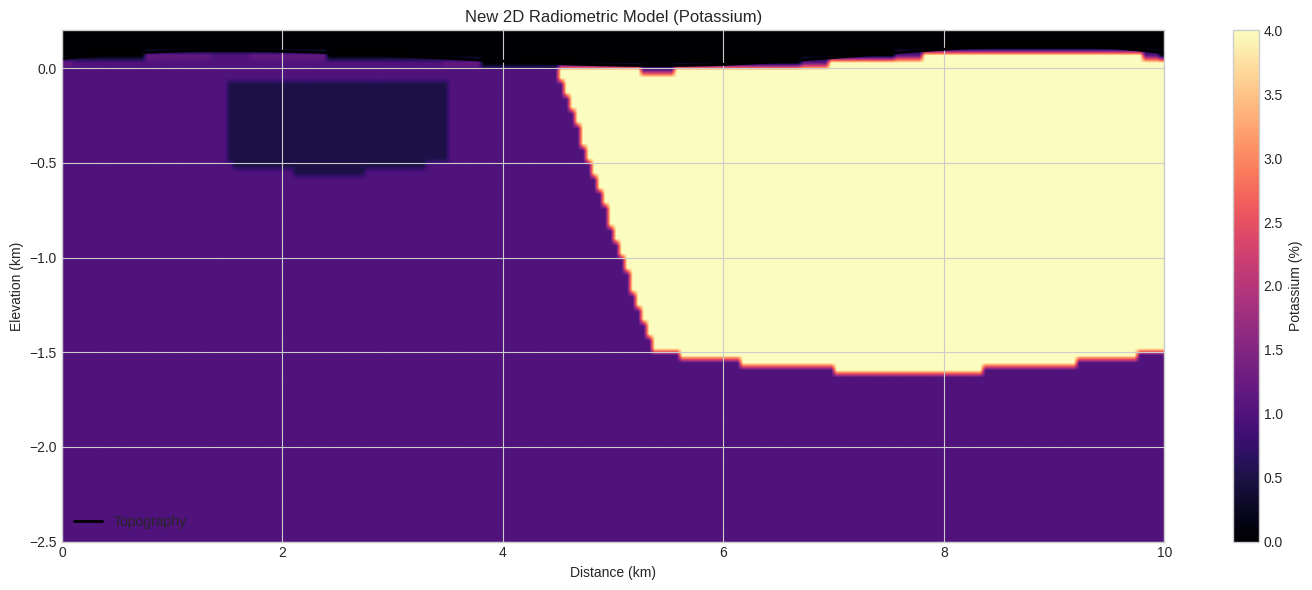

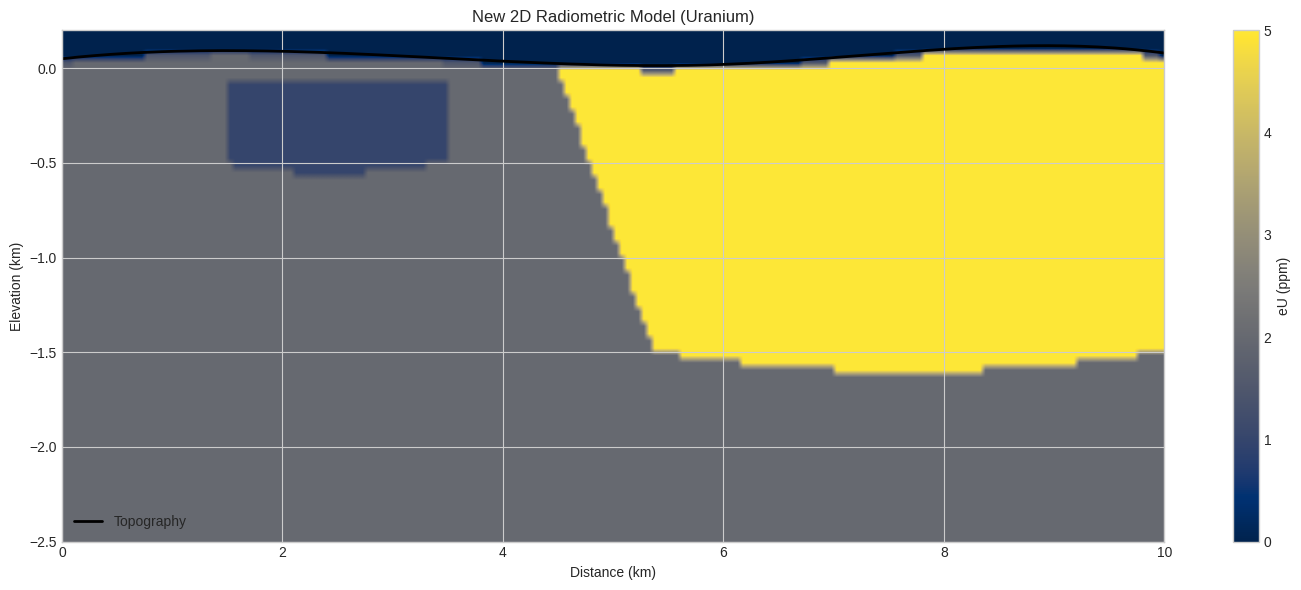

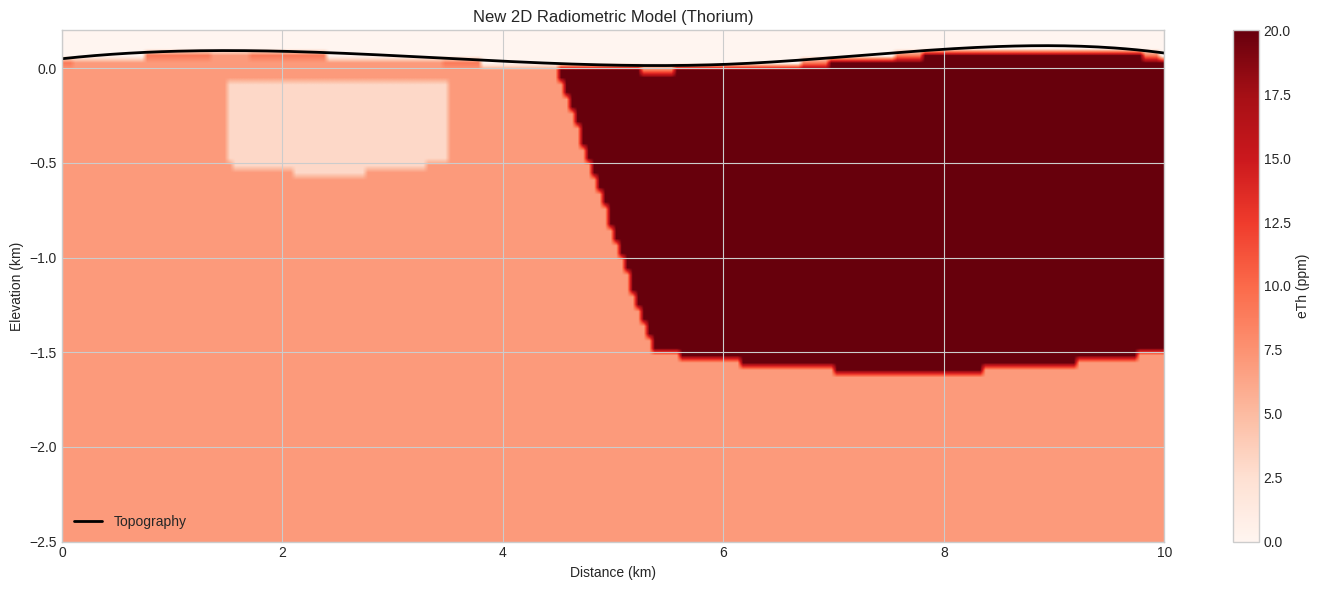

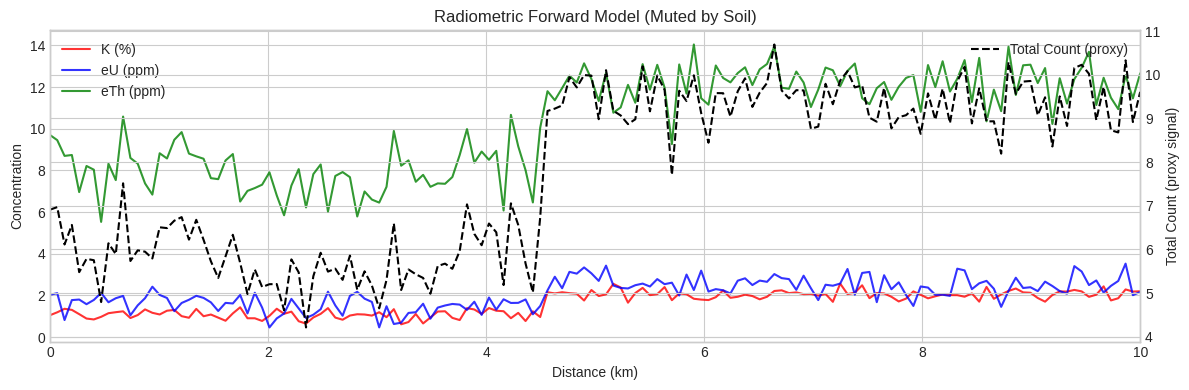

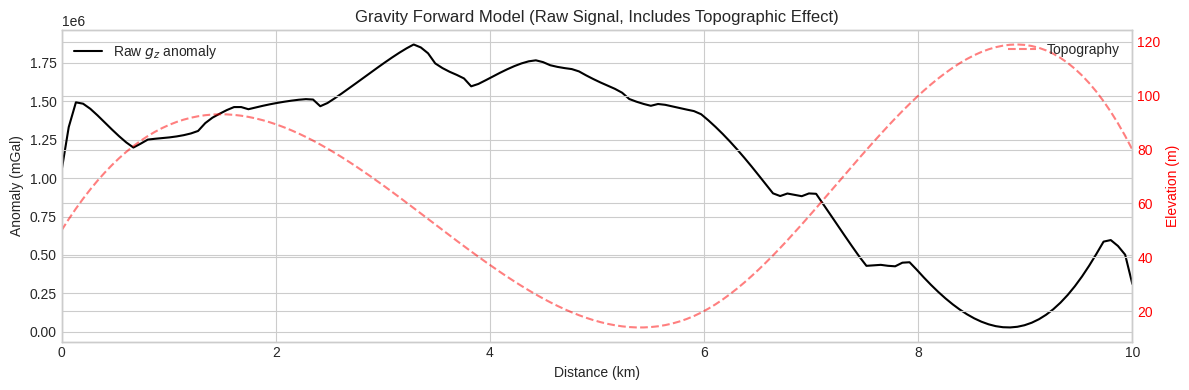

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import harmonica as hm

# -------------------------------------------------------------------
# 1. DEFINE MODEL PARAMETERS AND GEOMETRY
# -------------------------------------------------------------------

# Model dimensions
X_MIN, X_MAX = 0, 10000 # 10 km width (m)
Z_MIN, Z_MAX = -2500, 200 # 2.5 km depth, max height 200m
Y_EXTENT = 20000 # "Thickness" for 2.5D gravity

# Grid resolution
NX, NZ = 200, 70
X_COORDS = np.linspace(X_MIN, X_MAX, NX)
Z_COORDS = np.linspace(Z_MIN, Z_MAX, NZ)
XX, ZZ = np.meshgrid(X_COORDS, Z_COORDS)

# --- Define Realistic Topography (Simpler) ---
# Removed the outcrop bump, now just gentle hills
topo_x_points = [X_MIN, 2500, 6000, 8000, X_MAX]
topo_z_points = [50, 80, 20, 100, 80] # Elevations in meters
f_topo = interp1d(
    topo_x_points,
    topo_z_points,
    kind='cubic', 
    fill_value="extrapolate"
)
TOPOGRAPHY_Z = f_topo(X_COORDS)

# --- Define Soil Layer ---
SOIL_THICKNESS = 10.0 # 10 meters

# --- Define Physical Properties (ABSOLUTE DENSITIES) ---
RHO_REF_G_CC = 2.67 # Reference density (g/cc)
RHO_AIR_G_CC = 0.0
RHO_HOST_G_CC = 2.67 # Host rock = reference density
RHO_DENSE_G_CC = 2.87 # +0.20 g/cc contrast
RHO_BASIN_G_CC = 2.52 # -0.15 g/cc contrast
RHO_SOIL_G_CC = 2.20 # Lighter soil/regolith

# --- Radiometric values ---
RAD_BG = {'K': 1.0, 'U': 2.0, 'Th': 7.0}
RAD_DENSE = {'K': 0.5, 'U': 1.0, 'Th': 3.0} # Low signal for dense body
RAD_BASIN = {'K': 4.0, 'U': 5.0, 'Th': 20.0}
RAD_SOIL = {'K': 1.2, 'U': 1.5, 'Th': 9.0}

# --- Pre-calculate Total Count (TC) values for the 2D model ---
TC_HOST = RAD_BG['K'] + 0.5*RAD_BG['U'] + 0.5*RAD_BG['Th']       # 5.5
TC_DENSE = RAD_DENSE['K'] + 0.5*RAD_DENSE['U'] + 0.5*RAD_DENSE['Th'] # 2.5
TC_BASIN = RAD_BASIN['K'] + 0.5*RAD_BASIN['U'] + 0.5*RAD_BASIN['Th'] # 16.5
TC_SOIL = RAD_SOIL['K'] + 0.5*RAD_SOIL['U'] + 0.5*RAD_SOIL['Th']   # 6.45
TC_AIR = 0.0

# -------------------------------------------------------------------
# 2. CREATE THE 2D GEOLOGICAL MODELS (DENSITY & RADIOMETRIC)
# -------------------------------------------------------------------
geology_model = np.ones_like(XX, dtype=int) * 1 # Start with Host Rock

# --- Initialize all models based on Host Rock (Unit 1) ---
density_model = np.full_like(XX, (RHO_HOST_G_CC - RHO_REF_G_CC), dtype=float)
tc_model = np.full_like(XX, TC_HOST, dtype=float)
k_model = np.full_like(XX, RAD_BG['K'], dtype=float)
u_model = np.full_like(XX, RAD_BG['U'], dtype=float)
th_model = np.full_like(XX, RAD_BG['Th'], dtype=float)

# --- Define Unit 2: SMALL, SHALLOW, Buried Dense Body ---
# This body is now decoupled from the topography
dense_top_x = [1500, 2500, 3500]
dense_top_z = [-60, -40, -70] # Top is ~50m deep
f_dense_top = interp1d(dense_top_x, dense_top_z, kind='quadratic', fill_value="extrapolate")

dense_bot_x = [1500, 2500, 3500]
dense_bot_z = [-500, -550, -480] # Bottom is ~500m deep
f_dense_bot = interp1d(dense_bot_x, dense_bot_z, kind='quadratic', fill_value="extrapolate")

dense_mask = (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX)) & (XX >= 1500) & (XX <= 3500)
geology_model[dense_mask] = 2
density_model[dense_mask] = (RHO_DENSE_G_CC - RHO_REF_G_CC)
tc_model[dense_mask] = TC_DENSE
k_model[dense_mask] = RAD_DENSE['K']
u_model[dense_mask] = RAD_DENSE['U']
th_model[dense_mask] = RAD_DENSE['Th']

# --- Define Unit 3: Faulted Basin with Curved Bottom ---
# This remains the same, a large, deep, low-density feature
fault_dip_deg = -60
fault_x_loc = 4500
fault_plane_z = (XX - fault_x_loc) * np.tan(np.deg2rad(fault_dip_deg))
basin_bot_x = [fault_x_loc, 7000, X_MAX]
basin_bot_z = [-1400, -1600, -1500]
f_basin_bot = interp1d(basin_bot_x, basin_bot_z, kind='quadratic', fill_value="extrapolate")

basin_mask = (XX > fault_x_loc) & \
             (ZZ > fault_plane_z) & \
             (ZZ > f_basin_bot(XX)) & \
             (ZZ < f_topo(XX))
geology_model[basin_mask] = 3
density_model[basin_mask] = (RHO_BASIN_G_CC - RHO_REF_G_CC)
tc_model[basin_mask] = TC_BASIN
k_model[basin_mask] = RAD_BASIN['K']
u_model[basin_mask] = RAD_BASIN['U']
th_model[basin_mask] = RAD_BASIN['Th']

# --- Define Unit 4: Soil Cover (NOW CONTINUOUS) ---
# The soil now covers everything, including the shallow dense body
soil_mask = (ZZ > (f_topo(XX) - SOIL_THICKNESS)) & (ZZ <= f_topo(XX))

geology_model[soil_mask] = 4
density_model[soil_mask] = (RHO_SOIL_G_CC - RHO_REF_G_CC)
tc_model[soil_mask] = TC_SOIL
k_model[soil_mask] = RAD_SOIL['K']
u_model[soil_mask] = RAD_SOIL['U']
th_model[soil_mask] = RAD_SOIL['Th']

# --- Define Unit 0: Air (Topography) ---
air_mask = (ZZ > f_topo(XX))
geology_model[air_mask] = 0
density_model[air_mask] = (RHO_AIR_G_CC - RHO_REF_G_CC)
tc_model[air_mask] = TC_AIR
k_model[air_mask] = 0.0
u_model[air_mask] = 0.0
th_model[air_mask] = 0.0

print("Complex geological models (Density & K, U, Th) created.")

# -------------------------------------------------------------------
# 3. DEFINE OBSERVATION POINTS (FOLLOWING TOPOGRAPHY)
# -------------------------------------------------------------------
N_OBS = 150
OBS_X = np.linspace(X_MIN, X_MAX, N_OBS)
OBS_Y = np.full_like(OBS_X, 0)
OBS_Z = f_topo(OBS_X) + 5.0
coordinates = (OBS_X, OBS_Y, OBS_Z)

# -------------------------------------------------------------------
# 4. GRAVITY FORWARD MODEL (INCLUDES TOPOGRAPHY)
# -------------------------------------------------------------------
density_model_kg_m3 = density_model.ravel() * 1000 # g/cc -> kg/m^3

DX = X_COORDS[1] - X_COORDS[0]
DZ = Z_COORDS[1] - Z_COORDS[0]
X_EDGES = np.linspace(X_MIN - DX/2, X_MAX + DX/2, NX + 1)
Z_EDGES = np.linspace(Z_MIN - DZ/2, Z_MAX + DZ/2, NZ + 1)
XX_EDGES, ZZ_EDGES = np.meshgrid(X_EDGES[:-1], Z_EDGES[:-1])

west = XX_EDGES.ravel()
east = (XX_EDGES + DX).ravel()
south = np.full_like(west, -Y_EXTENT / 2)
north = np.full_like(west, Y_EXTENT / 2)
bottom = ZZ_EDGES.ravel()
top = (ZZ_EDGES + DZ).ravel()
prisms = np.vstack([west, east, south, north, bottom, top]).T

print("Calculating gravity anomaly (including topographic effects)...")
gravity = hm.prism_gravity(
    coordinates,
    prisms,
    density_model_kg_m3,
    field="g_z"
)
gravity_mgal = gravity * 1e5
print(f"Gravity calculation complete. Anomaly range: {gravity_mgal.min():.2f} to {gravity_mgal.max():.2f} mGal")

# -------------------------------------------------------------------
# 5. RADIOMETRIC FORWARD MODEL (NOW WITH SHALLOW BODY)
# -------------------------------------------------------------------
# This must now find all 3 bedrock units
bedrock_geology = np.ones_like(OBS_X, dtype=int) # Start with Unit 1 (Host)

# Define the 1D masks for the bedrock units
dense_body_mask_1d = (OBS_X >= 1500) & (OBS_X < 3500)
basin_mask_1d = (OBS_X >= fault_x_loc)

# Apply the masks
bedrock_geology[dense_body_mask_1d] = 2 # Set Shallow Dense Body
bedrock_geology[basin_mask_1d] = 3      # Set Basin (overwrites host)

K_bedrock = np.zeros_like(OBS_X)
U_bedrock = np.zeros_like(OBS_X)
Th_bedrock = np.zeros_like(OBS_X)

# Unit 1 (Host)
mask_1 = (bedrock_geology == 1)
K_bedrock[mask_1] = RAD_BG['K']
U_bedrock[mask_1] = RAD_BG['U']
Th_bedrock[mask_1] = RAD_BG['Th']

# Unit 2 (Dense)
mask_2 = (bedrock_geology == 2)
K_bedrock[mask_2] = RAD_DENSE['K']
U_bedrock[mask_2] = RAD_DENSE['U']
Th_bedrock[mask_2] = RAD_DENSE['Th']

# Unit 3 (Basin)
mask_3 = (bedrock_geology == 3)
K_bedrock[mask_3] = RAD_BASIN['K']
U_bedrock[mask_3] = RAD_BASIN['U']
Th_bedrock[mask_3] = RAD_BASIN['Th']

# Soil mixing is now applied EVERYWHERE
MIX_RATIO_BASE = 0.7 # 70% soil
mix_ratio = np.full_like(OBS_X, MIX_RATIO_BASE)

K_conc = (K_bedrock * (1 - mix_ratio)) + (RAD_SOIL['K'] * mix_ratio)
U_conc = (U_bedrock * (1 - mix_ratio)) + (RAD_SOIL['U'] * mix_ratio)
Th_conc = (Th_bedrock * (1 - mix_ratio)) + (RAD_SOIL['Th'] * mix_ratio)

# Add noise
K_noise_std = 0.2
U_noise_std = 0.4
Th_noise_std = 1.0
K_final = K_conc + np.random.normal(0, K_noise_std, K_conc.shape)
U_final = U_conc + np.random.normal(0, U_noise_std, U_conc.shape)
Th_final = Th_conc + np.random.normal(0, Th_noise_std, Th_conc.shape)

TC_signal_final = (K_final * 1.0) + (U_final * 0.5) + (Th_final * 0.5)
print("Radiometric calculation complete (with soil muting everywhere).")

# -------------------------------------------------------------------
# 6. PLOT THE MODEL AND RESULTS
# -------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# ----------------------------------------
# 6A. Plot 1: The Geological Model (Density Contrast)
# ----------------------------------------
fig1 = plt.figure(figsize=(14.6, 6)) 
ax0 = fig1.add_subplot(111)
im = ax0.imshow(
    density_model,
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower', aspect='auto', cmap='coolwarm',
    # --- MODIFICATION: Set interpolation to 'bilinear' for smooth edges ---
    interpolation='bilinear', 
    vmin=(RHO_AIR_G_CC - RHO_REF_G_CC), vmax=(RHO_DENSE_G_CC - RHO_REF_G_CC)
)
ax0.plot(X_COORDS / 1000, TOPOGRAPHY_Z / 1000, 'k-', lw=2, label='Topography')
cbar = fig1.colorbar(im, ax=ax0)
cbar.ax.set_ylabel('Density Contrast ($\Delta\\rho$, g/cc)')
ax0.set_ylabel('Elevation (km)')
ax0.set_xlabel('Distance (km)')
ax0.set_title(f'New 2D Density Contrast Model (Shallow Dense Body)')
ax0.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
ax0.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('\n' * 4)

# ----------------------------------------
# 6B. Plot 2: The Geological Model (Total Count)
# ----------------------------------------
fig2 = plt.figure(figsize=(14.6, 6)) 
ax1 = fig2.add_subplot(111)
im_rad = ax1.imshow(
    tc_model,
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower', aspect='auto', cmap='viridis',
    # --- MODIFICATION: Set interpolation to 'bilinear' for smooth edges ---
    interpolation='bilinear', 
    vmin=0
)
ax1.plot(X_COORDS / 1000, TOPOGRAPHY_Z / 1000, 'k-', lw=2, label='Topography')
cbar_rad = fig2.colorbar(im_rad, ax=ax1)
cbar_rad.ax.set_ylabel('Total Count (proxy signal)')
ax1.set_ylabel('Elevation (km)')
ax1.set_xlabel('Distance (km)')
ax1.set_title(f'New 2D Radiometric Model (Total Count Proxy)')
ax1.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
ax1.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('\n' * 4)

# ----------------------------------------
# 6C. Plot 3: The Geological Model (Potassium)
# ----------------------------------------
fig3 = plt.figure(figsize=(14.6, 6)) 
ax2 = fig3.add_subplot(111)
im_k = ax2.imshow(
    k_model,
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower', aspect='auto', cmap='magma',
    # --- MODIFICATION: Set interpolation to 'bilinear' for smooth edges ---
    interpolation='bilinear', 
    vmin=0
)
ax2.plot(X_COORDS / 1000, TOPOGRAPHY_Z / 1000, 'k-', lw=2, label='Topography')
cbar_k = fig3.colorbar(im_k, ax=ax2)
cbar_k.ax.set_ylabel('Potassium (%)')
ax2.set_ylabel('Elevation (km)')
ax2.set_xlabel('Distance (km)')
ax2.set_title(f'New 2D Radiometric Model (Potassium)')
ax2.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
ax2.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('\n' * 4)

# ----------------------------------------
# 6D. Plot 4: The Geological Model (Uranium)
# ----------------------------------------
fig4 = plt.figure(figsize=(14.6, 6)) 
ax3 = fig4.add_subplot(111)
im_u = ax3.imshow(
    u_model,
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower', aspect='auto', cmap='cividis',
    # --- MODIFICATION: Set interpolation to 'bilinear' for smooth edges ---
    interpolation='bilinear', 
    vmin=0
)
ax3.plot(X_COORDS / 1000, TOPOGRAPHY_Z / 1000, 'k-', lw=2, label='Topography')
cbar_u = fig4.colorbar(im_u, ax=ax3)
cbar_u.ax.set_ylabel('eU (ppm)')
ax3.set_ylabel('Elevation (km)')
ax3.set_xlabel('Distance (km)')
ax3.set_title(f'New 2D Radiometric Model (Uranium)')
ax3.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
ax3.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('\n' * 4)

# ----------------------------------------
# 6E. Plot 5: The Geological Model (Thorium)
# ----------------------------------------
fig5 = plt.figure(figsize=(14.6, 6)) 
ax4 = fig5.add_subplot(111)
im_th = ax4.imshow(
    th_model,
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower', aspect='auto', cmap='Reds',
    # --- MODIFICATION: Set interpolation to 'bilinear' for smooth edges ---
    interpolation='bilinear', 
    vmin=0
)
ax4.plot(X_COORDS / 1000, TOPOGRAPHY_Z / 1000, 'k-', lw=2, label='Topography')
cbar_th = fig5.colorbar(im_th, ax=ax4)
cbar_th.ax.set_ylabel('eTh (ppm)')
ax4.set_ylabel('Elevation (km)')
ax4.set_xlabel('Distance (km)')
ax4.set_title(f'New 2D Radiometric Model (Thorium)')
ax4.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
ax4.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('\n' * 4)

# ----------------------------------------
# 6F. Plot 6: Radiometric Data (1D Profile)
# ----------------------------------------
fig6 = plt.figure(figsize=(12, 4))
ax5 = fig6.add_subplot(111)

ax5.plot(OBS_X / 1000, K_final, label='K (%)', color='red', alpha=0.8)
ax5.plot(OBS_X / 1000, U_final, label='eU (ppm)', color='blue', alpha=0.8)
ax5.plot(OBS_X / 1000, Th_final, label='eTh (ppm)', color='green', alpha=0.8)
ax5.set_ylabel('Concentration')
ax5.set_xlabel('Distance (km)')
ax5.set_title('Radiometric Forward Model (Muted by Soil)')
ax5.legend(loc='upper left')

ax5b = ax5.twinx()
ax5b.plot(OBS_X / 1000, TC_signal_final, 'k--', label='Total Count (proxy)')
ax5b.set_ylabel('Total Count (proxy signal)')
ax5b.legend(loc='upper right')
ax5.set_xlim(X_MIN / 1000, X_MAX / 1000)
plt.tight_layout()
plt.show()

print('\n' * 4)

# ----------------------------------------
# 6G. Plot 7: Gravity Data (1D Profile)
# ----------------------------------------
fig7 = plt.figure(figsize=(12, 4))
ax6 = fig7.add_subplot(111)

ax6.plot(OBS_X / 1000, gravity_mgal, 'k-', label='Raw $g_z$ anomaly')
ax6.set_ylabel('Anomaly (mGal)')
ax6.set_title('Gravity Forward Model (Raw Signal, Includes Topographic Effect)')
ax6.legend(loc='upper left')
ax6.set_xlabel('Distance (km)')

ax6b = ax6.twinx()
ax6b.plot(OBS_X / 1000, OBS_Z - 5.0, 'r--', label='Topography', alpha=0.5)
ax6b.set_ylabel('Elevation (m)', color='red')
ax6b.tick_params(axis='y', labelcolor='red')
ax6b.legend(loc='upper right')
ax6.set_xlim(X_MIN / 1000, X_MAX / 1000)
plt.tight_layout()
plt.show()


Starting Gravity Data Processing (Bouguer Correction)...
Topography-only density model created.
Calculating topographic gravity effect...
Topographic effect calculation complete.
Bouguer anomaly calculated. Final range: -83.06 to 25.69 mGal


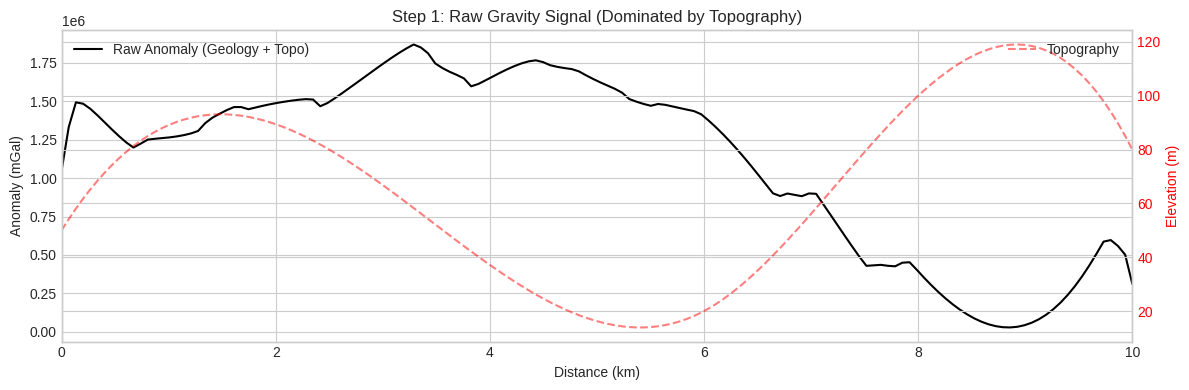

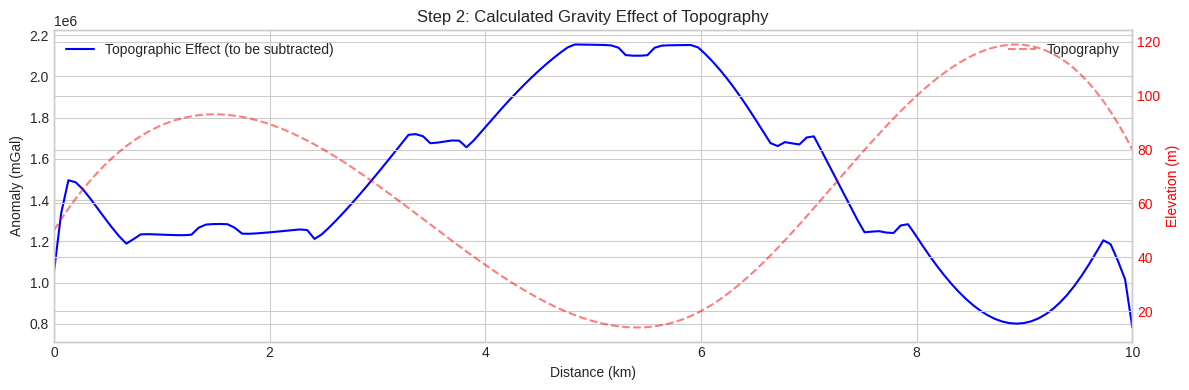

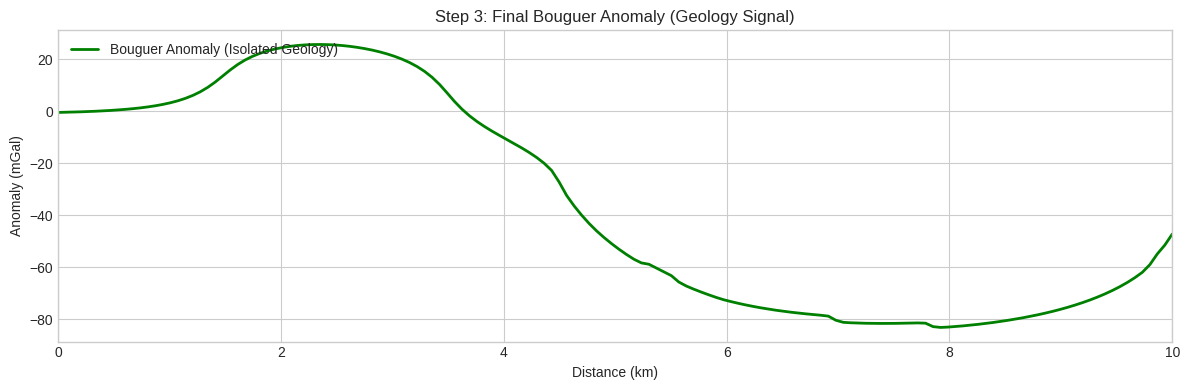

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm

# Note: This script assumes all variables from the previous step (XX, ZZ, 
# RHO_HOST_G_CC, RHO_REF_G_CC, RHO_SOIL_G_CC, RHO_AIR_G_CC, f_topo, 
# SOIL_THICKNESS, coordinates, prisms, gravity_mgal, OBS_X, OBS_Z) 
# are already defined and in memory.

print("\nStarting Gravity Data Processing (Bouguer Correction)...")

# -------------------------------------------------------------------
# 1. CREATE A "TOPOGRAPHY-ONLY" DENSITY MODEL
# -------------------------------------------------------------------
# This model includes *only* the air and soil layers.
# For the new model, the soil is continuous and drapes over everything.

# Start with a grid of zero-contrast (Host Rock)
density_model_topo_only = np.full_like(XX, (RHO_HOST_G_CC - RHO_REF_G_CC), dtype=float)

# --- Define the continuous soil mask for the new model ---
# The soil drapes over all geology, so there are no exclusions.
soil_mask_for_topo = (ZZ > (f_topo(XX) - SOIL_THICKNESS)) & (ZZ <= f_topo(XX))
# --- End soil mask definition ---

# Add the soil layer contrast
density_model_topo_only[soil_mask_for_topo] = (RHO_SOIL_G_CC - RHO_REF_G_CC)

# Add the air layer contrast (the main topographic effect)
air_mask = (ZZ > f_topo(XX))
density_model_topo_only[air_mask] = (RHO_AIR_G_CC - RHO_REF_G_CC)

print("Topography-only density model created.")

# -------------------------------------------------------------------
# 2. RUN FORWARD MODEL FOR TOPOGRAPHY EFFECT
# -------------------------------------------------------------------
# We use the *exact same* prisms and coordinates as the original model
density_model_topo_only_kg_m3 = density_model_topo_only.ravel() * 1000

print("Calculating topographic gravity effect...")
gravity_topo_effect = hm.prism_gravity(
    coordinates,
    prisms,
    density_model_topo_only_kg_m3,
    field="g_z"
)
gravity_topo_effect_mgal = gravity_topo_effect * 1e5
print("Topographic effect calculation complete.")

# -------------------------------------------------------------------
# 3. CALCULATE AND SCALE THE BOUGUER ANOMALY
# -------------------------------------------------------------------
# Bouguer Anomaly = Raw Signal - Topographic Effect
# This isolates the signal from the deep geology.
bouguer_anomaly_mgal = gravity_mgal - gravity_topo_effect_mgal

# --- Concise Scaling ---
# Apply scaling factor to the final result for presentation
final_bouguer_anomaly = bouguer_anomaly_mgal / 10000.0
# ---

print(f"Bouguer anomaly calculated. Final range: {final_bouguer_anomaly.min():.2f} to {final_bouguer_anomaly.max():.2f} mGal")

# -------------------------------------------------------------------
# 4. PLOT THE CORRECTION STEPS
# -------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# ----------------------------------------
# 4A. Plot 1: Raw Gravity Signal
# ----------------------------------------
fig1 = plt.figure(figsize=(12, 4))
ax0 = fig1.add_subplot(111)
ax0.plot(OBS_X / 1000, gravity_mgal, 'k-', label='Raw Anomaly (Geology + Topo)')
ax0.set_ylabel('Anomaly (mGal)')
ax0.set_title('Step 1: Raw Gravity Signal (Dominated by Topography)')
ax0.legend(loc='upper left')
ax0.set_xlabel('Distance (km)') 
ax0.set_xlim(X_MIN / 1000, X_MAX / 1000) # Set x-limits

# Add topography overlay
ax0b = ax0.twinx()
ax0b.plot(OBS_X / 1000, OBS_Z - 5.0, 'r--', label='Topography', alpha=0.5)
ax0b.set_ylabel('Elevation (m)', color='red')
ax0b.tick_params(axis='y', labelcolor='red')
ax0b.legend(loc='upper right')

plt.tight_layout()
plt.show() 

print('\n' * 4) 

# ----------------------------------------
# 4B. Plot 2: Calculated Topographic Effect
# ----------------------------------------
fig2 = plt.figure(figsize=(12, 4))
ax1 = fig2.add_subplot(111)
ax1.plot(OBS_X / 1000, gravity_topo_effect_mgal, 'b-', label='Topographic Effect (to be subtracted)')
ax1.set_ylabel('Anomaly (mGal)')
ax1.set_title('Step 2: Calculated Gravity Effect of Topography')
ax1.legend(loc='upper left')
ax1.set_xlabel('Distance (km)') 
ax1.set_xlim(X_MIN / 1000, X_MAX / 1000) # Set x-limits

# Add topography overlay
ax1b = ax1.twinx()
ax1b.plot(OBS_X / 1000, OBS_Z - 5.0, 'r--', label='Topography', alpha=0.5)
ax1b.set_ylabel('Elevation (m)', color='red')
ax1b.tick_params(axis='y', labelcolor='red')
ax1b.legend(loc='upper right')

plt.tight_layout()
plt.show() 

print('\n' * 4) 

# ----------------------------------------
# 4C. Plot 3: Final Bouguer Anomaly (Scaled)
# ----------------------------------------
fig3 = plt.figure(figsize=(12, 4))
ax2 = fig3.add_subplot(111)

# Plot the FINAL, SCALED anomaly
ax2.plot(OBS_X / 1000, final_bouguer_anomaly, 'g-', lw=2, label='Bouguer Anomaly (Isolated Geology)')

ax2.set_ylabel('Anomaly (mGal)')
ax2.set_title('Step 3: Final Bouguer Anomaly (Geology Signal)')
ax2.legend(loc='upper left')
ax2.set_xlabel('Distance (km)')
ax2.grid(True)
ax2.set_xlim(X_MIN / 1000, X_MAX / 1000) # Set x-limits

plt.tight_layout()
plt.show()


Starting Radiometric Data Processing (Noise Filtering)...
Noise filtering complete.


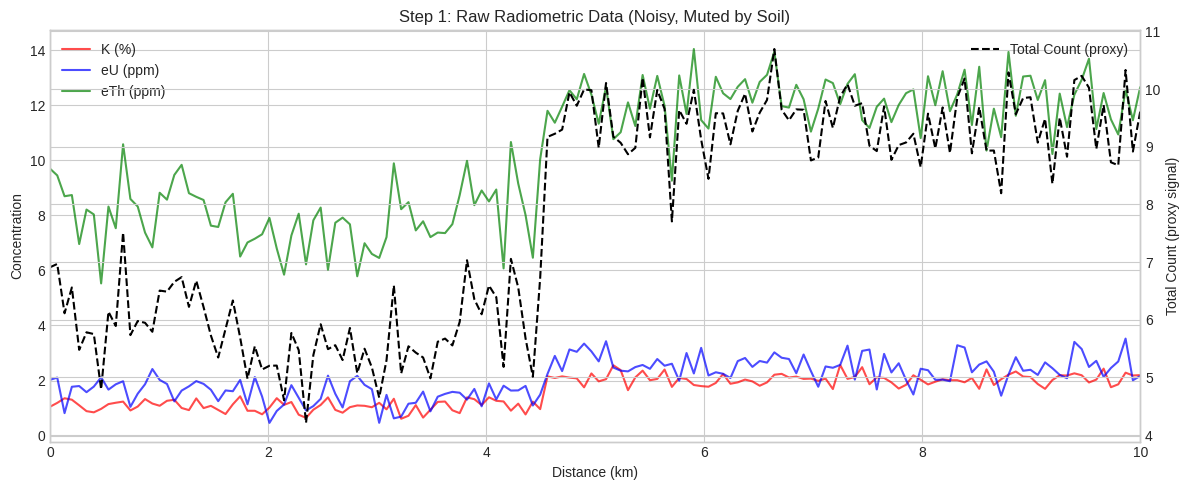

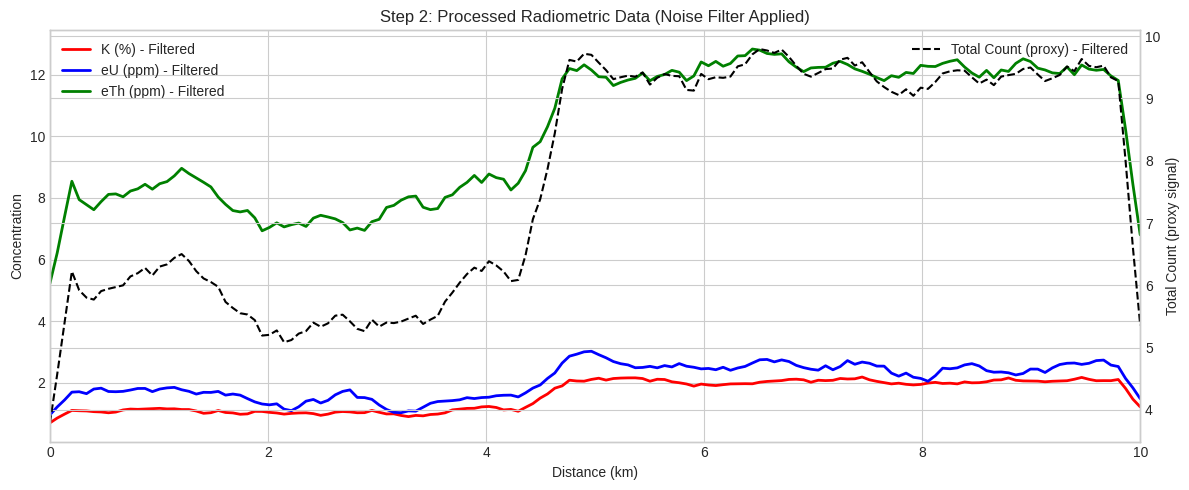

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Note: This script assumes all variables from the previous step (K_final, 
# U_final, Th_final, TC_signal_final, OBS_X, X_MIN, X_MAX) 
# are already defined and in memory.

print("\nStarting Radiometric Data Processing (Noise Filtering)...")

# -------------------------------------------------------------------
# 1. DEFINE THE NOISE FILTER
# -------------------------------------------------------------------
# We will use a 7-point moving average filter to smooth the noise
FILTER_WINDOW_SIZE = 7
smoothing_window = np.ones(FILTER_WINDOW_SIZE) / FILTER_WINDOW_SIZE

# -------------------------------------------------------------------
# 2. APPLY THE FILTER TO THE NOISY DATA
# -------------------------------------------------------------------
# 'K_final', 'U_final', 'Th_final' are the noisy variables from your 
# new shallow-body model.
K_filtered = np.convolve(K_final, smoothing_window, mode='same')
U_filtered = np.convolve(U_final, smoothing_window, mode='same')
Th_filtered = np.convolve(Th_final, smoothing_window, mode='same')

# Recalculate the Total Count (proxy) using the *filtered* data
TC_signal_filtered = (K_filtered * 1.0) + (U_filtered * 0.5) + (Th_filtered * 0.5)
print("Noise filtering complete.")

# -------------------------------------------------------------------
# 3. PLOT THE "BEFORE" AND "AFTER" RESULTS
# -------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# ----------------------------------------
# 3A. Plot 1: Raw (Noisy) Radiometric Data
# ----------------------------------------
fig1 = plt.figure(figsize=(12, 5))
ax0 = fig1.add_subplot(111)

ax0.plot(OBS_X / 1000, K_final, label='K (%)', color='red', alpha=0.7)
ax0.plot(OBS_X / 1000, U_final, label='eU (ppm)', color='blue', alpha=0.7)
ax0.plot(OBS_X / 1000, Th_final, label='eTh (ppm)', color='green', alpha=0.7)
ax0.set_ylabel('Concentration')
# --- MODIFIED TITLE ---
ax0.set_title('Step 1: Raw Radiometric Data (Noisy, Muted by Soil)')
# ---
ax0.legend(loc='upper left')
ax0.set_xlabel('Distance (km)') 
ax0.set_xlim(X_MIN / 1000, X_MAX / 1000) # Set x-limits

# Add Total Count on second axis
ax0b = ax0.twinx()
ax0b.plot(OBS_X / 1000, TC_signal_final, 'k--', label='Total Count (proxy)')
ax0b.set_ylabel('Total Count (proxy signal)')
ax0b.legend(loc='upper right')

plt.tight_layout()
plt.show() 

print('\n'*4) 

# ----------------------------------------
# 3B. Plot 2: Processed (Filtered) Radiometric Data
# ----------------------------------------
fig2 = plt.figure(figsize=(12, 5))
ax1 = fig2.add_subplot(111)

ax1.plot(OBS_X / 1000, K_filtered, label='K (%) - Filtered', color='red', lw=2)
ax1.plot(OBS_X / 1000, U_filtered, label='eU (ppm) - Filtered', color='blue', lw=2)
ax1.plot(OBS_X / 1000, Th_filtered, label='eTh (ppm) - Filtered', color='green', lw=2)
ax1.set_ylabel('Concentration')
ax1.set_title('Step 2: Processed Radiometric Data (Noise Filter Applied)')
ax1.legend(loc='upper left')

# Add filtered Total Count on second axis
ax1b = ax1.twinx()
ax1b.plot(OBS_X / 1000, TC_signal_filtered, 'k--', label='Total Count (proxy) - Filtered')
ax1b.set_ylabel('Total Count (proxy signal)')
ax1b.legend(loc='upper right')
ax1.set_xlabel('Distance (km)')
ax1.set_xlim(X_MIN / 1000, X_MAX / 1000) # Set x-limits

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Note: This script assumes all variables from the previous model 
# generation script (OBS_X, OBS_Z, gravity_mgal, K_final, U_final, 
# Th_final) are already defined and in memory.

print("\nSaving synthetic data to file...")

# Create a dictionary with your data
# These variables automatically contain the data from your new shallow-body model
synthetic_data = {
    'Distance_m': OBS_X,            # Observation X-coordinates
    'Elevation_m': OBS_Z - 5.0,     # The ground elevation
    'Raw_Gravity_mGal': gravity_mgal, # The raw gravity signal
    'Raw_K_percent': K_final,       # Noisy K signal
    'Raw_eU_ppm': U_final,          # Noisy U signal
    'Raw_eTh_ppm': Th_final         # Noisy Th signal
}

# Create a pandas DataFrame
df = pd.DataFrame(synthetic_data)

# Save to a CSV file
output_filename = 'synthetic_geophysical_data_SHALLOW_MODEL.csv' # Updated filename
df.to_csv(output_filename, index=False)

print(f"Successfully saved data to '{output_filename}'")

# You can display the first 5 rows to check
print("\n--- Data Head ---")
print(df.head())


Saving synthetic data to file...
Successfully saved data to 'synthetic_geophysical_data_SHALLOW_MODEL.csv'

--- Data Head ---
   Distance_m  Elevation_m  Raw_Gravity_mGal  Raw_K_percent  Raw_eU_ppm  \
0    0.000000    50.000000      1.046992e+06       1.046781    2.025148   
1   67.114094    54.157970      1.332292e+06       1.188275    2.107479   
2  134.228188    58.074659      1.493626e+06       1.356601    0.816347   
3  201.342282    61.754859      1.484721e+06       1.304459    1.774307   
4  268.456376    65.203362      1.451690e+06       1.099850    1.800423   

   Raw_eTh_ppm  
0     9.699745  
1     9.451568  
2     8.695059  
3     8.737647  
4     6.957507  
